In [1]:
import numpy as np
import pandas as pd
from numpy.random import beta
from numpy.random import normal
from numpy.random import gamma
import matplotlib.pyplot as plt
import os
from scipy.stats import ks_2samp
from scipy.stats import wilcoxon

# Parameters recovery

## Difficulty/Discrimination and Ability

In [2]:
N = 250 # Respondents
M = 50 # Items

a_prior_mean = 0
a_prior_std = 1.0

np.random.seed(42)

ability = beta(a = 1.0, b = 1.0, size = N)
difficulty = beta(a = 1.0, b = 1.0, size = M)
discrimination = np.abs(normal(loc = a_prior_mean, scale = a_prior_std, size = M))
parameters = np.array([difficulty, discrimination]).T

## Estimating Alpha and Beta parameters

In [3]:
def Alpha_ij(theta_i, delta_j, a_j):
    div = delta_j/theta_i
    alpha = div ** (a_j)
    return alpha

In [4]:
def Beta_ij(theta_i, delta_j, a_j):
    num = (1 - delta_j)
    denom = (1 - theta_i)
    div = num/denom
    beta = div ** (a_j)
    return beta

In [5]:
Alpha = np.zeros((M, N))
Beta = np.zeros((M, N))
for i, params in enumerate(parameters):
    for j, theta in enumerate(ability):
        Alpha[i, j] = Alpha_ij(theta, params[0], params[1])
        Beta[i, j] = Beta_ij(theta, params[0], params[1])

## Estimating the errors from Gamma distribution

In [6]:
# Gamma parameterisation
# shape, scale, = alpha, 1/beta

errors = np.clip(gamma(shape = Alpha, scale = 1/Beta), 1e-7, 7000)

In [7]:
np.amax(errors)

7000.0

In [8]:
# responses = 1/(1 + errors)
# responses = np.clip(responses, 1e-7, 1-1e-7)

In [9]:
# name = 'irt_data_recovery_s' + str(M) + '_f0_sd0.csv'
# header = str(list(range(N)))[1:-1]
# np.savetxt('./beta_irt/' + name, responses.T, delimiter=',', header=header)

## Inference to find new Parameters and Abilities

In [10]:
import pymc3 as pm

def alpha_calc(theta, delta, a):
    return pm.math.clip(pm.math.dot(delta, (1.0 / theta))**a, 1e-7, np.inf)
#     Alpha = np.zeros((M, N))
#     for i in range(N):
#         div = delta/theta[i]
#         Alpha[:, i] = div ** a
#     return Alpha


def beta_calc(theta, delta, a):
    return pm.math.clip(pm.math.dot(1.0 - delta, 1.0 / (1.0 - theta))**a, 1e-7, np.inf)
#     Beta = np.zeros((M, N))
#     for i in range(N):
#         num = (1 - delta)
#         denom = (1 - theta[i])
#         div = num/denom
#         Beta[:, i] = div ** a
#     return Beta

with pm.Model() as linear_model:
    ab_pred = pm.Beta('ability', alpha=1, beta=1, shape=(1, N))
    dif_pred = pm.Beta('difficulty', alpha=1, beta=1, shape=(M, 1))
    dis_pred = pm.HalfNormal('discrimination', sigma=1, shape=(M, 1))
    errors_observed = pm.Gamma('errors_observed',
                alpha=pm.Deterministic('al', alpha_calc(ab_pred, dif_pred, dis_pred)),
                beta=pm.Deterministic('be', beta_calc(ab_pred, dif_pred, dis_pred)),
                observed=errors)

    prior = pm.sample_prior_predictive()
    posterior = pm.sample(5000, random_seed=42)
    posterior_pred = pm.sample_posterior_predictive(posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [discrimination, difficulty, ability]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [37:34<00:00,  9.76draws/s]
The acceptance probability does not match the target. It is 0.9163478854345611, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 20000/20000 [01:12<00:00, 275.83it/s]


In [11]:
ab_rec = posterior.get_values('ability').mean(axis=0)

In [12]:
dif_rec = posterior.get_values('difficulty').mean(axis=0)

In [14]:
disc_rec = posterior.get_values('discrimination').mean(axis=0)

In [89]:
# os.chdir('./beta_irt/')
# os.system('python betairt_test.py ' + name)
# os.chdir('..')
import sys
sys.path.append('./student-experiments/')

import tensorflow as tf
from edward.models import Normal,Beta,Gamma,TransformedDistribution,InverseGamma
from models.gamma_irt import Gamma_IRT
   
niter = 1500

theta = Beta(tf.ones([N]),tf.ones([N]), sample_shape=[M], name='theta')
delta = Beta(tf.ones([M]),tf.ones([M]), sample_shape=[N], name='delta')
a = Normal(tf.ones(M) * a_prior_mean,tf.ones([M]) * a_prior_std,
    sample_shape=[N], name='a')

model = Gamma_IRT(M, N, theta, delta, a, n_iter=niter)

D = np.clip(np.float32(errors), 1e-4, np.inf)

ab_rec, dif_rec, disc_rec = model.fit(D)

ModuleNotFoundError: No module named 'tensorflow'

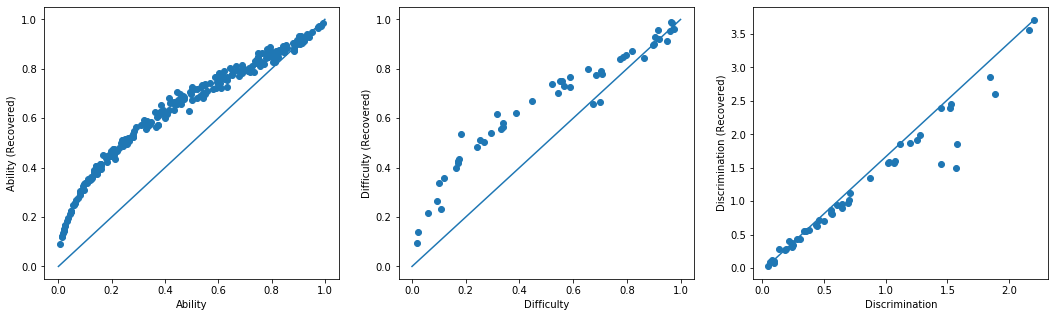

In [16]:
fig, axes = plt.subplots(nrows= 1, ncols= 3, figsize=(18,5))
axes[0].scatter(ability, ab_rec.flatten())
axes[0].set_xlabel('Ability')
axes[0].set_ylabel('Ability (Recovered)')
axes[0].plot([0, 1], [0, 1])

axes[1].scatter(difficulty, dif_rec.flatten())
axes[1].set_xlabel('Difficulty')
axes[1].set_ylabel('Difficulty (Recovered)')
axes[1].plot([0, 1], [0, 1])

axes[2].scatter(discrimination, disc_rec.flatten())
axes[2].set_xlabel('Discrimination')
axes[2].set_ylabel('Discrimination (Recovered)')
axes[2].plot([min(discrimination), max(discrimination)], [min(disc_rec), max(disc_rec)])


In [14]:
print(wilcoxon(ability, ab_rec.flatten()))
print(wilcoxon(difficulty, dif_rec.flatten()))

WilcoxonResult(statistic=3372.0, pvalue=5.2889714111398116e-27)
WilcoxonResult(statistic=0.0, pvalue=7.556929455863566e-10)


In [17]:
from scipy.stats import kstest

print(ks_2samp(ability, ab_rec.flatten()))
print(ks_2samp(difficulty, dif_rec.flatten()))
print(ks_2samp(discrimination, disc_rec.flatten()))

Ks_2sampResult(statistic=0.288, pvalue=1.5327069250319869e-09)
Ks_2sampResult(statistic=0.3, pvalue=0.02170784069014051)
Ks_2sampResult(statistic=0.22, pvalue=0.17858668181221732)


In [30]:
parameters_ = pd.read_csv('./beta_irt/results/recovery/irt_parameters_vi_recovery_s' + str(len(difficulty)) + '_f0_sd0_am1@0_as1@0.csv')
ability_ = pd.read_csv('./beta_irt/results/recovery/irt_ability_vi_recovery_s' + str(len(difficulty)) + '_f0_sd0_am1@0_as1@0.csv')

FileNotFoundError: [Errno 2] File b'./beta_irt/results/recovery/irt_parameters_vi_recovery_s50_f0_sd0_am1@0_as1@0.csv' does not exist: b'./beta_irt/results/recovery/irt_parameters_vi_recovery_s50_f0_sd0_am1@0_as1@0.csv'

WilcoxonResult(statistic=478.0, pvalue=0.12363399711559386)
WilcoxonResult(statistic=458.0, pvalue=0.08313770889364551)
WilcoxonResult(statistic=48881.0, pvalue=2.1182717558476713e-05)


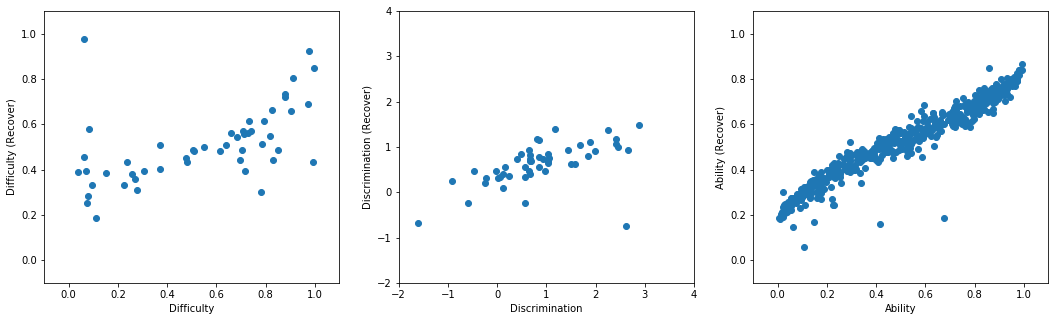

In [20]:
fig, axes = plt.subplots(nrows= 1, ncols= 3, figsize=(18,5))
labels = ['Difficulty', 'Discrimination']
for i in range(parameters.shape[1]):
    axes[i].scatter(parameters[:, i], parameters_.values[:, i])
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel(labels[i] + ' (Recover)')
    print(wilcoxon(parameters[:, i], parameters_.values[:, i]))
axes[-1].scatter(ability, ability_.iloc[:-1, -1].values)
axes[-1].set_xlabel('Ability')
axes[-1].set_ylabel('Ability (Recover)')

for i in [0,2]:
    axes[i].set_xlim([-.1,1.1])
    axes[i].set_ylim([-.1,1.1])
axes[1].set_xlim([-2,4])
axes[1].set_ylim([-2,4])
print(wilcoxon(ability, ability_.iloc[:-1, -1].values))